<font color="gray">

### 0. Ensure CUDA and torch is loaded correctly


Also ensure on Rockfish that you are using only 1/however GPUs you specified, not 4

</font>

In [ ]:
!export CUDA_VISIBLE_DEVICES=0

In [1]:
!nvidia-smi

Fri Oct 11 11:37:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:17:00.0 Off |                    0 |
| N/A   48C    P0              106W / 300W|   2447MiB / 81920MiB |     95%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import torch
print(torch.cuda.device_count())

1


If the below says 10.2, you will get the `sm_80` CUDA compatibility warning

In [3]:
torch.version.cuda

'11.3'

# 1. Load Tensors

In [2]:
# Load cubes that were sampled using this random_state. In this notebook, everything is deterministic
random_state = 1

In [ ]:
import os
import torch
import pickle
from pathlib import Path

# Define the base path based on the random state
base_path = Path(f'data/generated-data/cube_samples/random_seed_{random_state}')

# Load 96^3 cube samples
all_sampled_cubes = torch.load(os.path.join(base_path, 'ct_cubes_tensor.pt'))

# # Load the sampled data from the directory specified by the random state
# sampled_points_multi_organ_labels = torch.load(base_path / 'sample_point_ground_truths.pt')
# sampled_points_coordinates = torch.load(base_path / 'sample_coordinates.pt')

# Load the list of patient IDs
with open(base_path / 'filtered_ids.pkl', 'rb') as f:
    all_filtered_ids = pickle.load(f)

print(all_sampled_cubes.shape)
print(all_filtered_ids[:10])
assert len(all_sampled_cubes) == len(all_filtered_ids)

In [30]:
import nibabel as nib

first_ct = nib.load("data/healthy-pancreas/BDMAP_00000002/ct.nii.gz")

## (Optional) Save/Load Stuff from Disk

In [ ]:
import os

# Define the HuggingFace repository and local path
ct_filename = "ct.nii.gz"
pancreas_segmentations_filename = "segmentations/pancreas.nii.gz"

data_folder = "./data"
healthy_pancreas_folder = os.path.join(data_folder, "healthy-pancreas")
pancreatic_tumor_folder = os.path.join(data_folder, "pancreatic-tumor")

os.makedirs(healthy_pancreas_folder, exist_ok=True)
os.makedirs(pancreatic_tumor_folder, exist_ok=True)


pancreatic_tumor_ids = [
    'BDMAP_00000087',
    'BDMAP_00000093',
    'BDMAP_00000192',
    'BDMAP_00000225',
    'BDMAP_00000243',
    'BDMAP_00000324',
    'BDMAP_00000332',
    'BDMAP_00000416',
    'BDMAP_00000541',
    'BDMAP_00000696',
    'BDMAP_00000714',
    'BDMAP_00000715',
    'BDMAP_00000855',
    'BDMAP_00000940',
    'BDMAP_00000956',
    'BDMAP_00001040',
    'BDMAP_00001067',
    'BDMAP_00001096',
    'BDMAP_00001125',
    'BDMAP_00001205',
    'BDMAP_00001331',
    'BDMAP_00001461',
    'BDMAP_00001464',
    'BDMAP_00001476',
    'BDMAP_00001523',
    'BDMAP_00001564',
    'BDMAP_00001605',
    'BDMAP_00001617',
    'BDMAP_00001646',
    'BDMAP_00001649',
    'BDMAP_00001704',
    'BDMAP_00001746',
    'BDMAP_00001754',
    'BDMAP_00001823',
    'BDMAP_00001862',
    'BDMAP_00002021',
    'BDMAP_00002278',
    'BDMAP_00002298',
    'BDMAP_00002328',
    'BDMAP_00002387',
    'BDMAP_00002402',
    'BDMAP_00002616',
    'BDMAP_00002690',
    'BDMAP_00002793',
    'BDMAP_00002944',
    'BDMAP_00002945',
    'BDMAP_00003017',
    'BDMAP_00003036',
    'BDMAP_00003133',
    'BDMAP_00003141',
    'BDMAP_00003244',
    'BDMAP_00003326',
    'BDMAP_00003347',
    'BDMAP_00003427',
    'BDMAP_00003440',
    'BDMAP_00003451',
    'BDMAP_00003502',
    'BDMAP_00003551',
    'BDMAP_00003590',
    'BDMAP_00003592',
    'BDMAP_00003612',
    'BDMAP_00003658',
    'BDMAP_00003744',
    'BDMAP_00003776',
    'BDMAP_00003781',
    'BDMAP_00003812',
    'BDMAP_00004060',
    'BDMAP_00004106',
    'BDMAP_00004128',
    'BDMAP_00004229',
    'BDMAP_00004231',
    'BDMAP_00004447',
    'BDMAP_00004494',
    'BDMAP_00004511',
    'BDMAP_00004672',
    'BDMAP_00004770',
    'BDMAP_00004804',
    'BDMAP_00004847',
    'BDMAP_00004880',
    'BDMAP_00004927',
    'BDMAP_00004964',
    'BDMAP_00004969',
    'BDMAP_00004992',
    'BDMAP_00005020',
    'BDMAP_00005022',
    'BDMAP_00005070',
    'BDMAP_00005074',
    'BDMAP_00005075',
    'BDMAP_00005185'
]


healthy_pancreas_ids = [
    'BDMAP_00000002',
    'BDMAP_00000110',
    'BDMAP_00000198',
    'BDMAP_00000246',
    'BDMAP_00000351',
    'BDMAP_00000598',
    'BDMAP_00000673',
    'BDMAP_00000682',
    'BDMAP_00000764',
    'BDMAP_00000846',
    'BDMAP_00000878',
    'BDMAP_00000928',
    'BDMAP_00001002',
    'BDMAP_00001348',
    'BDMAP_00001662',
    'BDMAP_00001774',
    'BDMAP_00001820',
    'BDMAP_00001871',
    'BDMAP_00001942',
    'BDMAP_00001943',
    'BDMAP_00002059',
    'BDMAP_00002212',
    'BDMAP_00002236',
    'BDMAP_00002569',
    'BDMAP_00002650',
    'BDMAP_00002753',
    'BDMAP_00002763',
    'BDMAP_00003013',
    'BDMAP_00003033',
    'BDMAP_00003085',
    'BDMAP_00003154',
    'BDMAP_00003265',
    'BDMAP_00003577',
    'BDMAP_00003644',
    'BDMAP_00003876',
    'BDMAP_00004098',
    'BDMAP_00004142',
    'BDMAP_00004202',
    'BDMAP_00004360',
    'BDMAP_00004458',
    'BDMAP_00004480',
    'BDMAP_00005110'
]

In [ ]:
encoded_images_dir = os.path.join(data_folder, "encoded_imgs")

### Save Enc_cubes as dict object using Pickle

#### 2.4.1.1 Save to Pickle

In [ ]:
import pickle

with open(os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl'), 'wb') as f:
    pickle.dump(enc_healthy_cubes, f)

with open(os.path.join(encoded_images_dir, 'enc_pancreatic_tumor_cubes.pkl'), 'wb') as f:
    pickle.dump(enc_pancreatic_tumor_cubes, f)

#### 2.4.1.2 Load from Pickle

In [20]:
import os

os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl')

'./data/encoded_imgs/enc_healthy_cubes.pkl'

In [21]:
import pickle

with open(os.path.join(encoded_images_dir, 'enc_healthy_cubes.pkl'), 'rb') as f:
    enc_healthy_cubes = pickle.load(f)

with open(os.path.join(encoded_images_dir, 'enc_pancreatic_tumor_cubes.pkl'), 'rb') as f:
    enc_pancreatic_tumor_cubes = pickle.load(f)

In [22]:
print("len enc_healthy_cubes:", len(enc_healthy_cubes))
print("len enc_pancreatic_tumor_cubes:", len(enc_pancreatic_tumor_cubes))

len enc_healthy_cubes: 42
len enc_pancreatic_tumor_cubes: 37


### Save/Load encoded images as NII.GZ for viewing in ITK-SNAP

In [ ]:
from tqdm import tqdm
import os
import nibabel as nib

def save_images_as_nifti(cts, folder_ids, save_dir):
    """
    Saves a list of NIfTI images (nibabel.Nifti1Image) in folders named 
    after the original filenames, with a progress bar.

    Args:
        cts (list of nibabel.Nifti1Image): List of NIfTI images representing the CT images.
        folder_ids (list of str): List of strings representing the original filenames.
        save_dir (str): Directory where the NIfTI files will be saved.

    Returns:
        None
    """
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Initialize tqdm progress bar for the number of encoded images
    for ct_nifti, filename in tqdm(zip(cts, folder_ids), desc="Saving NIfTI files", unit="image"):
        # Create a folder named after the filename inside the save directory
        folder_path = os.path.join(save_dir, filename)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Get the data, affine, and header from the NIfTI image object
        ct_data = ct_nifti.get_fdata()
        affine = ct_nifti.affine
        header = ct_nifti.header

        # Create a new NIfTI image using nibabel (same data, affine, and header)
        new_ct_nifti = nib.Nifti1Image(ct_data, affine, header=header)

        # Define the file path for saving
        file_path = os.path.join(folder_path, 'ct.nii.gz')

        # Save the NIfTI image as a .nii.gz file
        nib.save(new_ct_nifti, file_path)

    print(f"All NIfTI files saved successfully in '{save_dir}'")

In [ ]:
encoded_imgs_folder = "encoded_imgs"
healthy_enc_imgs_folder = os.path.join(data_folder, encoded_imgs_folder, "healthy-pancreas")
pancreatic_tumor_enc_imgs_folder = os.path.join(data_folder, encoded_imgs_folder, "pancreatic-tumor")

In [ ]:
save_images_as_nifti(healthy_pancreas_enc_img_pairs, healthy_enc_imgs_folder)

In [ ]:
save_images_as_nifti(pancreas_tumor_enc_img_pairs, pancreatic_tumor_enc_imgs_folder)

Saving NIfTI files: 100%|██████████| 89/89 [00:28<00:00,  3.13image/s]

All NIfTI files saved successfully in './data/encoded_imgs/pancreatic-tumor'


### (Optional) Directly load saved encoded images

In [13]:
import os

encoded_imgs_folder = "encoded_imgs"
healthy_enc_imgs_folder = os.path.join(data_folder, encoded_imgs_folder, "healthy-pancreas")
pancreatic_tumor_enc_imgs_folder = os.path.join(data_folder, encoded_imgs_folder, "pancreatic-tumor")

In [14]:
healthy_patient_enc_img_folders = [os.path.join(healthy_enc_imgs_folder, j) for j in healthy_pancreas_ids]
pancreatic_tumor_enc_img_folders = [os.path.join(pancreatic_tumor_enc_imgs_folder, j) for j in pancreatic_tumor_ids]

In [18]:
from tqdm import tqdm
import nibabel as nib

def load_encoded_imgs_in_folders(folders_list: list):
    encoded_cts = []
    for path in tqdm(folders_list, desc="Loading Encoded CT Scans"):
        encoded_cts.append(nib.load(os.path.join(path, ct_filename)).get_fdata())

    return encoded_cts

In [ ]:
healthy_pancreas_enc_imgs = load_encoded_imgs_in_folders(healthy_patient_enc_img_folders)
pancreatic_tumor_enc_imgs = load_encoded_imgs_in_folders(pancreatic_tumor_enc_img_folders)

In [ ]:
type(healthy_pancreas_enc_imgs[0])

numpy.ndarray

In [ ]:
healthy_pancreas_enc_imgs[0].shape

(100, 78, 50, 8)

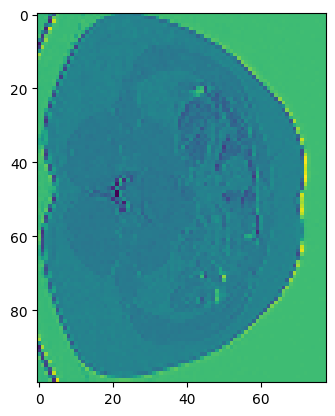

In [ ]:
from matplotlib import pyplot as plt


plt.imshow(healthy_pancreas_enc_imgs[0][:,:,0, 0])

# 2. Encode Images using VQ-GAN Encoder

<font color="color: #ff7f50;">

- [x] Take $96^3$ subcubes

- - [ ] Take different size subcubes? GAN wasn't trained on different sizes

</font>

- [x] <font color="gray"><s>Deal w/ padding</s></font>

<font color="blue">

## 2.1 Load Encoder model from DiffTumor

</font>

In [4]:
%cd STEP1.AutoencoderModel/

/scratch4/randalburns/DiffTumor/STEP1.AutoencoderModel


In [ ]:
import torch
from vq_gan_3d.model.vqgan import VQGAN
import numpy as np

# Load the pretrained VQGAN model
vqgan_ckpt = '../STEP2.DiffusionModel/pretrained_models/AutoencoderModel.ckpt'
vqgan_model = VQGAN.load_from_checkpoint(vqgan_ckpt).cuda()
vqgan_model.eval()

In [6]:
%cd ..

/scratch4/randalburns/DiffTumor


## 2.2 Input Images into Encoder

Do not use Codebook for first run. Use plain Encoder output

- [ ] Fix error when running with Tiling
- [X] Loop over all images - both Healthy and Unhealthy
- [ ] Future: plot Codebook itself
- [X] <font color="gray"><s>Why 12 extra channels? Just no. tiles that fit in image</s></font>

In [7]:
from tqdm import tqdm

# Define a function to encode 3D CT scans using the encoder from VQGAN
def encode_ct_scan(img_data):
    img_data_tensor = torch.tensor(img_data, dtype=torch.float32).to(vqgan_model.device)
    img_data_tensor = img_data_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimension (B, C, D, H, W)

    with torch.no_grad():
        encoded_img = vqgan_model.encode(img_data_tensor, quantize=False, include_embeddings=True)

    return encoded_img.cpu()


def encode_ct_scans_batch(img_data_batch, model, device='cuda', batch_size=16):
    """
    Encodes a batch of 3D CT scan cubes using the VQGAN encoder.

    Args:
        img_data_batch (torch.Tensor): Tensor of shape (N, 1, D, H, W).
        model (VQGAN): The pretrained VQGAN model.
        device (str): Device to perform computation on ('cuda' or 'cpu').
        batch_size (int): Number of samples to process in each sub-batch.

    Returns:
        torch.Tensor: Encoded tensor of shape (N, 8, 24, 24, 24).
    """
    encoded_batches = []
    num_samples = img_data_batch.size(0)
    
    with torch.no_grad():
        for start_idx in tqdm(range(0, num_samples, batch_size), desc="Encoding Batches"):
            end_idx = min(start_idx + batch_size, num_samples)
            batch = img_data_batch[start_idx:end_idx].to(device)  # Shape: (batch_size, 1, 96, 96, 96)
            
            # Pass through the encoder
            encoded = model.encode(batch, quantize=False, include_embeddings=True)  # Assuming output shape: (batch_size, 8, 24, 24, 24)
            
            encoded_batches.append(encoded.cpu())
    
    # Concatenate all encoded batches
    encoded_all = torch.cat(encoded_batches, dim=0)  # Shape: (N, 8, 24, 24, 24)
    return encoded_all

In [8]:
def encode_all_cts(all_sampled_cubes, vqgan_model, batch_size=16):
    """
    Encodes all CT scan cubes and returns the encoded tensor and corresponding patient IDs.

    Args:
        all_sampled_cubes (torch.Tensor): Tensor of shape [52, 55, 96, 96, 96].
        vqgan_model (VQGAN): The pretrained VQGAN model.
        batch_size (int): Batch size for encoding.

    Returns:
        torch.Tensor: Encoded tensor of shape [52, 55, 8, 24, 24, 24].
    """
    num_cts, num_cubes, D, H, W = all_sampled_cubes.shape
    total_cubes = num_cts * num_cubes

    # Reshape to [N, 1, D, H, W]
    all_cubes_reshaped = all_sampled_cubes.view(total_cubes, 1, D, H, W)  # Shape: [52*55, 1, 96, 96, 96]
    
    # Encode in batches
    encoded_cubes = encode_ct_scans_batch(all_cubes_reshaped, vqgan_model, device='cuda', batch_size=batch_size)
    # Shape: [52*55, 8, 24, 24, 24]
    
    # Reshape back to [52, 55, 8, 24, 24, 24]
    encoded_cubes_final = encoded_cubes.view(num_cts, num_cubes, 8, 24, 24, 24)
    
    return encoded_cubes_final

In [11]:
first_encoded_ct = encode_ct_scan(first_ct.get_fdata())

In [12]:
first_encoded_ct.shape

torch.Size([1, 8, 100, 78, 50])

In [8]:
all_encoded_cubes = encode_all_cts(all_sampled_cubes, vqgan_model, batch_size=16)

Encoding Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:26<00:00,  5.62it/s]


## Save Encoded data

In [9]:
def save_encoded_data(encoded_tensor, patient_ids, tensor_path='vqgan_encoded_96.pt', ids_path='all_filtered_ids.pkl'):
    """
    Saves the encoded tensor and patient IDs to disk.

    Args:
        encoded_tensor (torch.Tensor): Encoded tensor to save.
        patient_ids (List[str]): List of patient IDs.
        tensor_path (str): File path to save the tensor.
        ids_path (str): File path to save the patient IDs.
    """
    import torch
    import pickle

    # Save the tensor
    torch.save(encoded_tensor, tensor_path)
    print(f"Encoded tensor saved to {tensor_path}")

    # Save the patient IDs
    with open(ids_path, 'wb') as f:
        pickle.dump(patient_ids, f)
    print(f"Patient IDs saved to {ids_path}")

In [ ]:
all_encoded_cubes.shape

torch.Size([43, 55, 8, 24, 24, 24])

In [ ]:
import os

torch.save(all_encoded_cubes, os.path.join(base_path, 'vqgan_encoded_96.pt'))

In [10]:
# save_encoded_data(all_encoded_cubes, all_filtered_ids, tensor_path='data/generated-data/vqgan_encoded_96.pt', ids_path='data/all_filtered_ids.pkl')

Encoded tensor saved to data/vqgan_encoded_96.pt
Patient IDs saved to data/all_filtered_ids.pkl


# 3 Plot Encoded Images. How do these encoded image channels look like?
- [X] Use Gray cmap
- [x] Flip 90deg so front faces up
- [X] Re-create nii.gz file?

## Plot full raw CT vs. Encoded full CT

In [28]:
enc_img = first_encoded_ct.squeeze()

In [31]:
first_ct_np = first_ct.get_fdata()

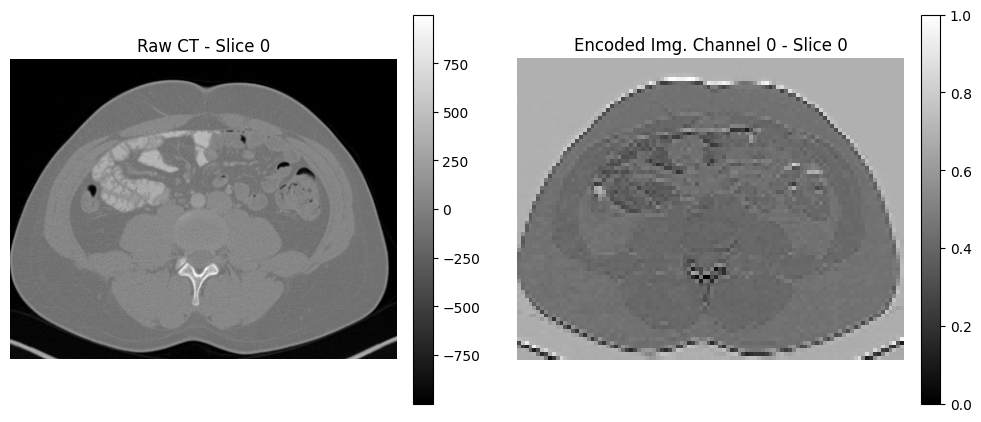

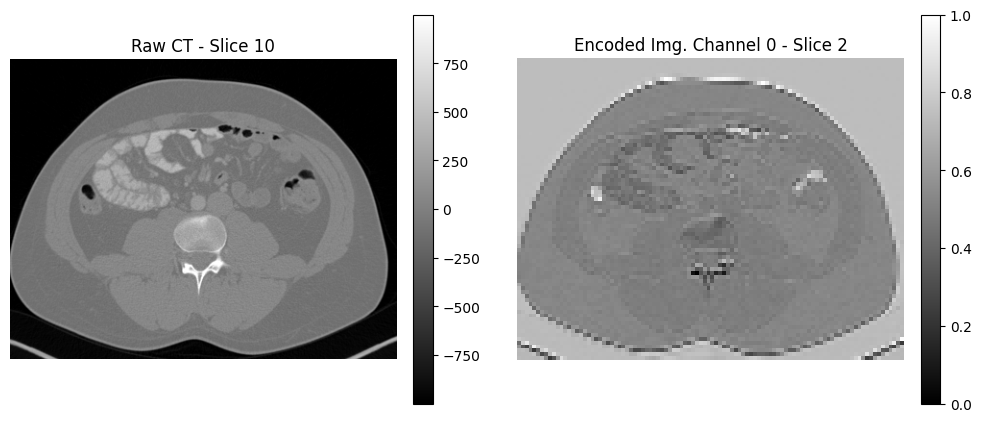

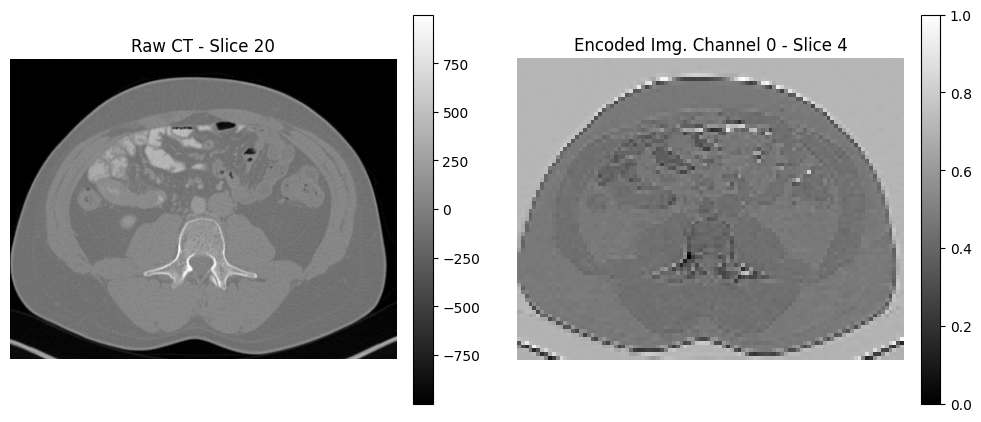

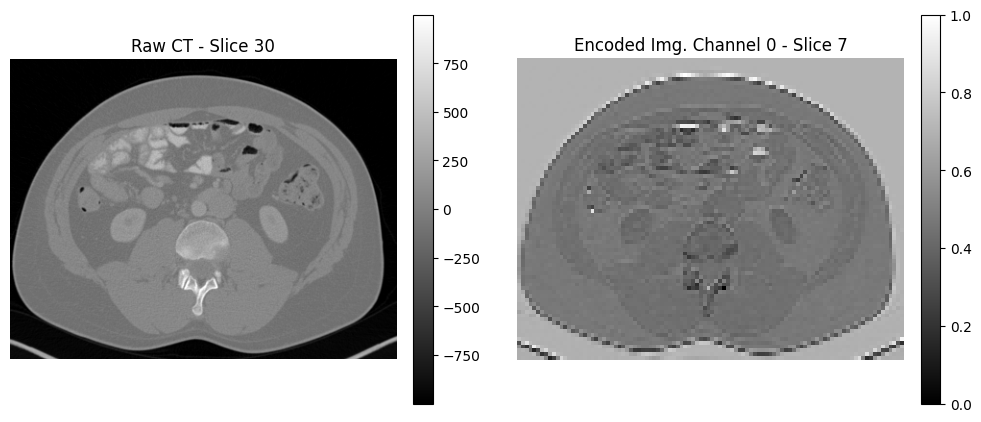

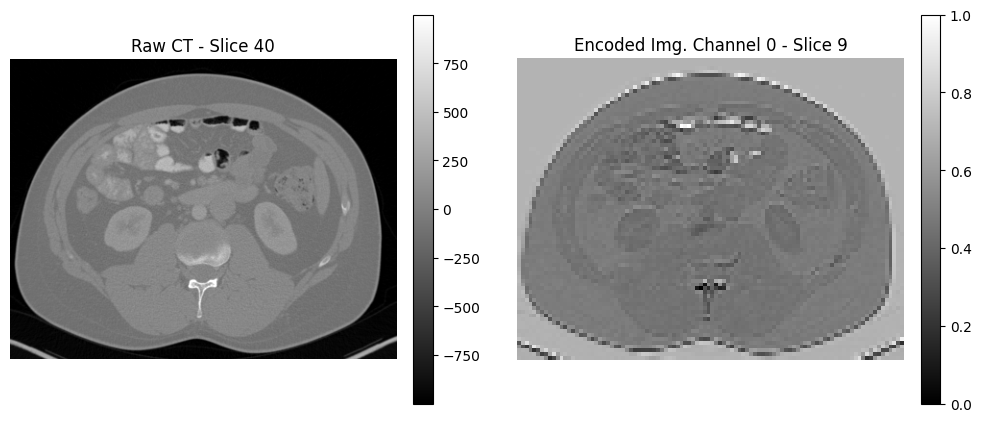

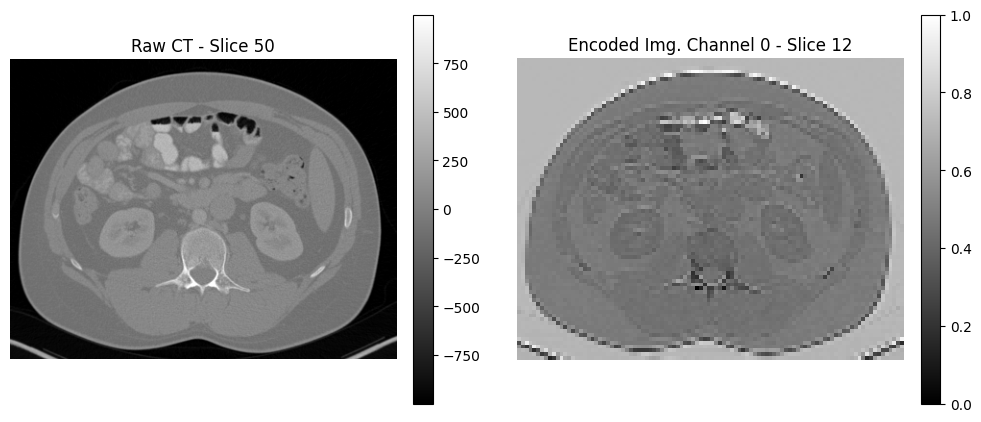

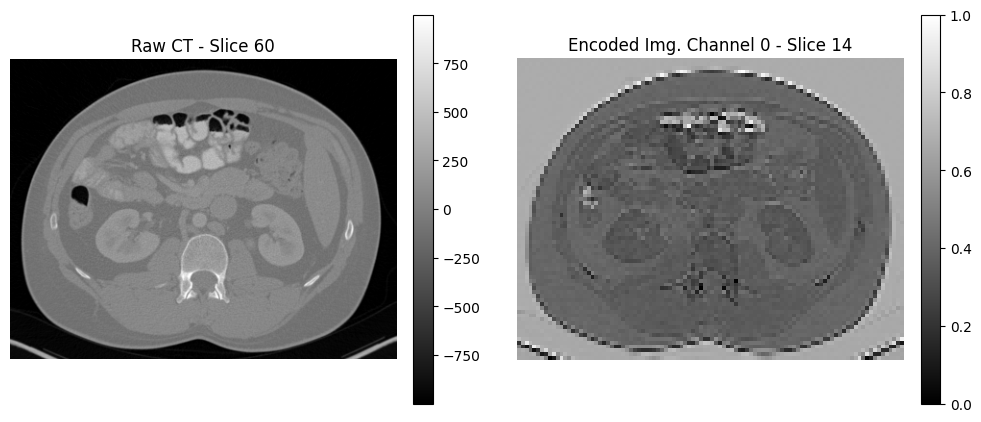

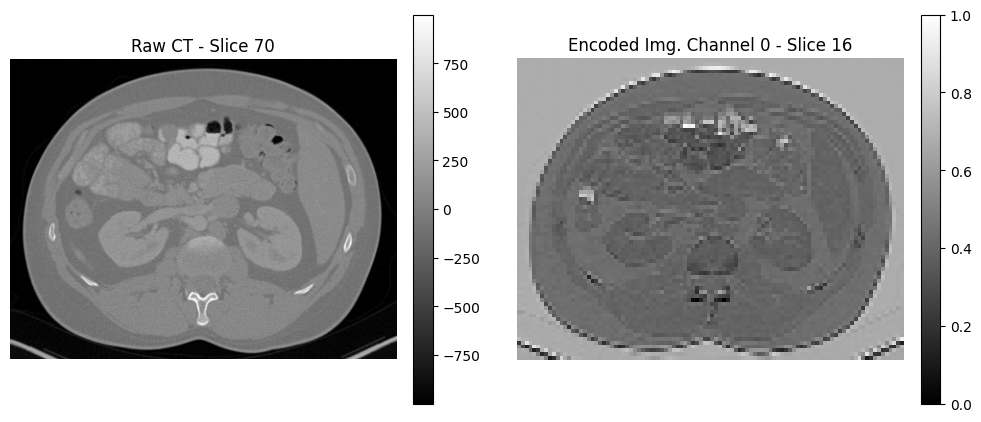

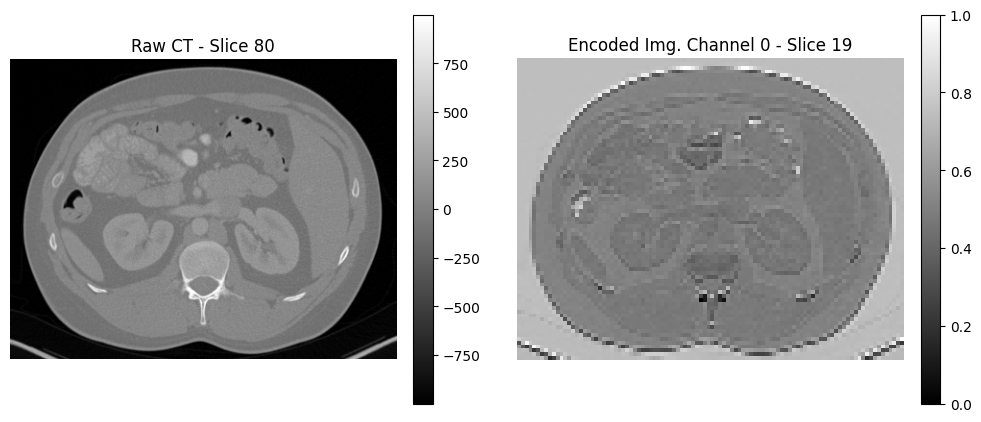

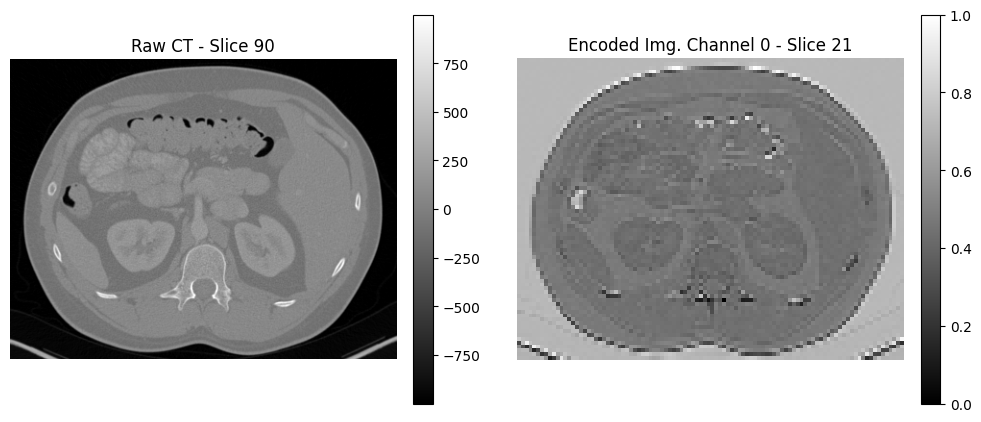

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Loop for side-by-side plotting
for i in range(10):  # Both loops generate 10 plots
    slice_idx_1 = i * 10  # From the first loop (0-96, step 10)
    slice_idx_2 = i * 2.4  # From the second loop (0-24), scaling to match the count

    # Create a figure with 2 subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Rotate and normalize the first image
    img_1 = first_ct_np[:, :, int(slice_idx_1)]
    # Don't normalize the CT
    img_1_normalized = img_1 # (img_1 - img_1.min()) / (img_1.max() - img_1.min())  # Normalization to [0, 1]
    rotated_img_1 = np.rot90(img_1_normalized)
    ax[0].imshow(rotated_img_1, cmap="gray")
    ax[0].set_title(f"Raw CT - Slice {int(slice_idx_1)}")
    ax[0].axis('off')  # Remove axis for cleaner visualization

    # Rotate and normalize the second image
    channel_idx = 0
    img_2 = enc_img[channel_idx, :, :, int(slice_idx_2)].cpu().numpy()
    img_2_normalized = (img_2 - img_2.min()) / (img_2.max() - img_2.min())  # Normalization to [0, 1]
    rotated_img_2 = np.rot90(img_2_normalized)
    ax[1].imshow(rotated_img_2, cmap="gray")
    ax[1].set_title(f"Encoded Img. Channel {channel_idx} - Slice {int(slice_idx_2)}")
    ax[1].axis('off')  # Remove axis for cleaner visualization

    # Add colorbars to each subplot
    fig.colorbar(ax[0].images[0], ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(ax[1].images[0], ax=ax[1], fraction=0.046, pad=0.04)

    # Display the figure
    plt.show()

### Save each channel of the encoding into its own nii.gz file

In [32]:
import nibabel as nib
import numpy as np
import torch

# Assume 'first_ct' is your original CT data and 'ct_img' is the loaded NIfTI image
# Assume 'enc_img' is your encoded image tensor with shape (8, 24, 24, 24)

# Load the original CT scan
ct_img = first_ct
ct_data = ct_img.get_fdata()
affine = ct_img.affine
header = ct_img.header

# Get the scaling factor between original and encoded images
original_shape = ct_data.shape  # Should be (96, 96, 96)
encoded_shape = enc_img.shape[1:]  # Should be (24, 24, 24)
scaling_factor = np.array(original_shape) / np.array(encoded_shape)  # [4, 4, 4]

# Adjust the affine transformation
new_affine = affine.copy()
for i in range(3):
    new_affine[:3, i] *= scaling_factor[i]

# Adjust the header
new_header = header.copy()
new_header['pixdim'][1:4] *= scaling_factor
new_header.set_data_dtype(np.float32)  # Ensure data type is float32

# Scaling parameters to match HU range (-1000 to 1000)
scale_min = -1000
scale_max = 1000
scale_range = scale_max - scale_min

# Save each channel as a separate NIfTI file
for c in range(8):
    # Extract the data for the current channel
    enc_channel_data = enc_img[c, :, :, :].cpu().numpy()
    
    # Scale the data to match HU range
    scaled_enc_channel_data = enc_channel_data * scale_range + scale_min
    
    # Create the NIfTI image
    new_img = nib.Nifti1Image(scaled_enc_channel_data, affine=new_affine, header=new_header)
    
    # Save the image
    nib.save(new_img, f'results/encoded_ct_nii_gz/encoded_channel_{c}.nii.gz')

## Plot vs. $96^3$

In [16]:
enc_img = enc_healthy_cubes['BDMAP_00000002'][0].squeeze()

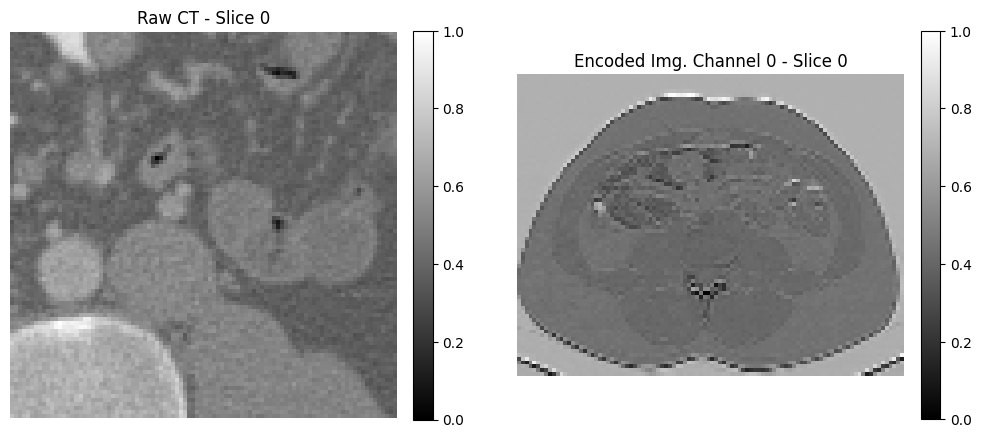

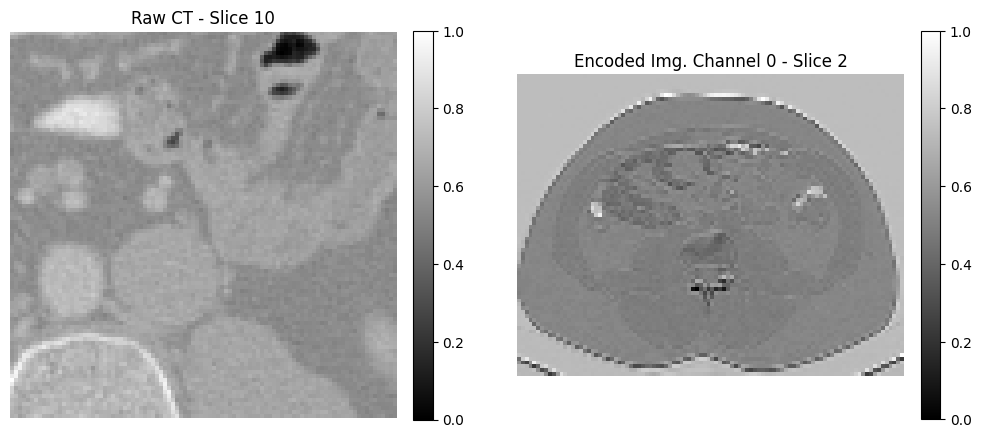

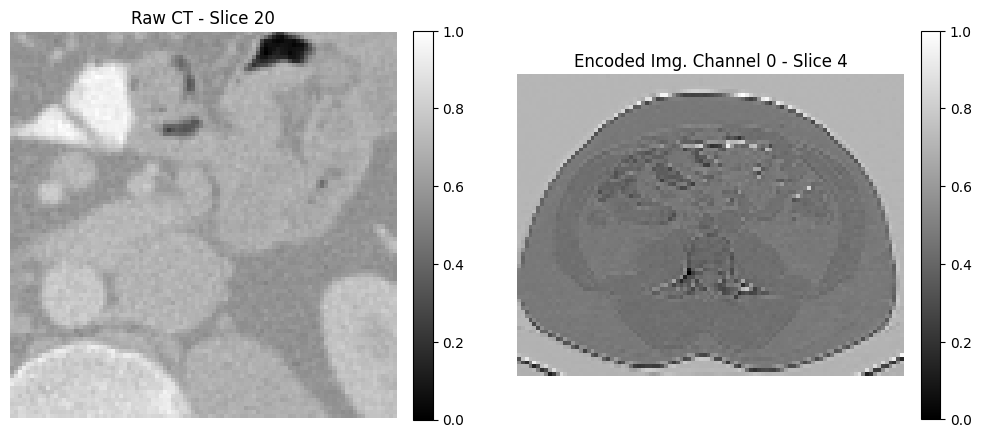

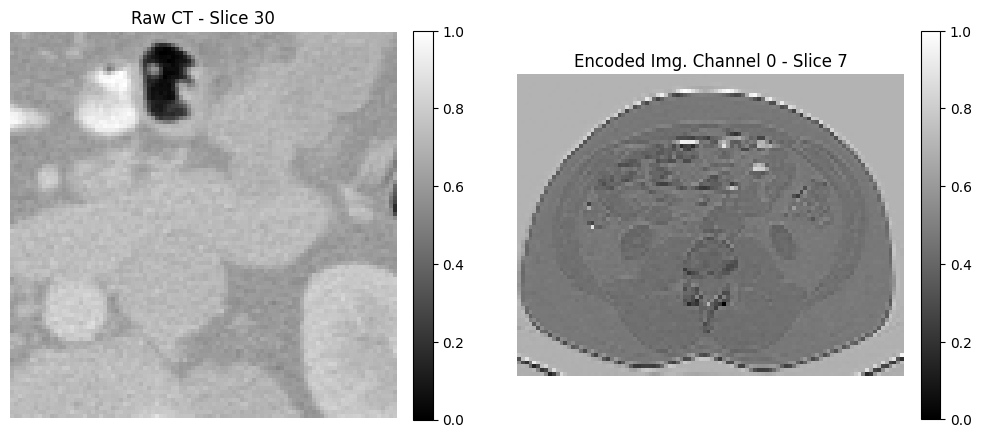

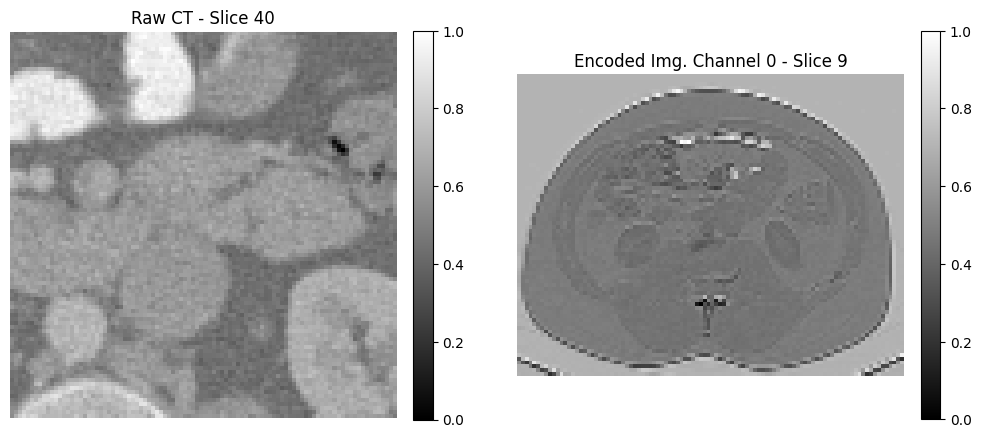

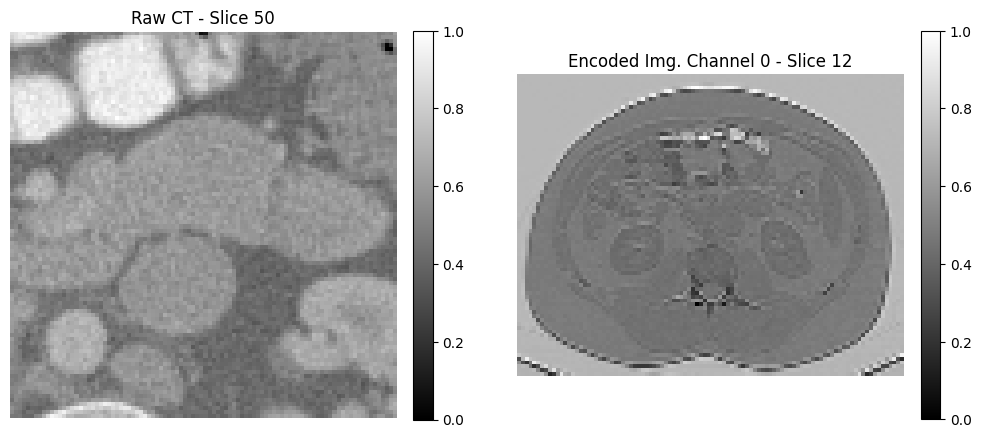

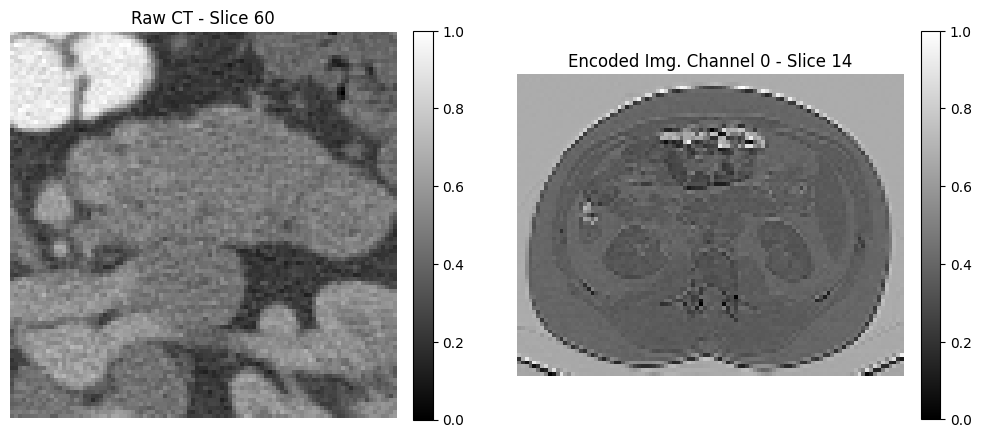

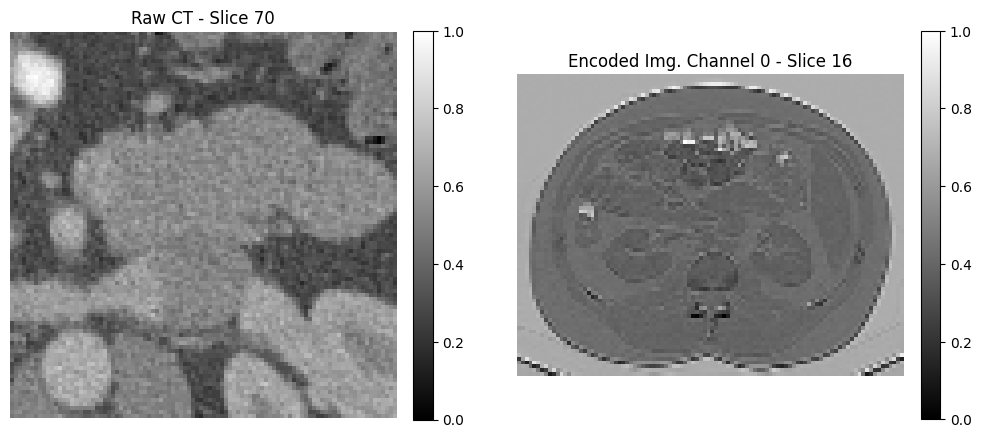

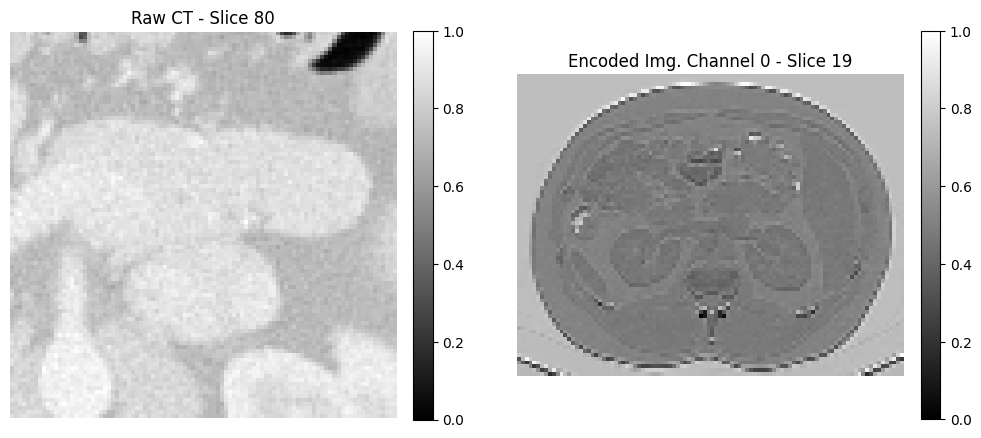

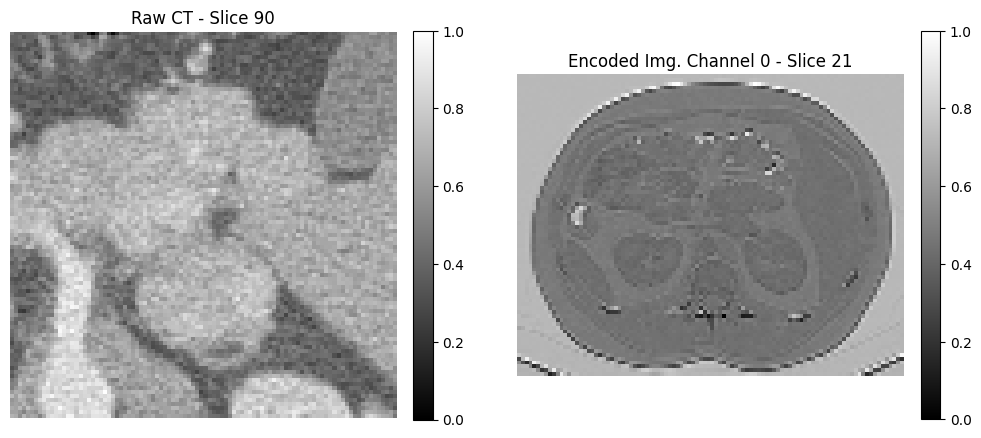

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Loop for side-by-side plotting
for i in range(10):  # Both loops generate 10 plots
    slice_idx_1 = i * 10  # From the first loop (0-96, step 10)
    slice_idx_2 = i * 2.4  # From the second loop (0-24), scaling to match the count

    # Create a figure with 2 subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Rotate and normalize the first image
    img_1 = all_sampled_cubes[0, 0, :, :, int(slice_idx_1)].cpu().numpy()
    img_1_normalized = (img_1 - img_1.min()) / (img_1.max() - img_1.min())  # Normalization to [0, 1]
    rotated_img_1 = np.rot90(img_1_normalized)
    ax[0].imshow(rotated_img_1, cmap="gray")
    ax[0].set_title(f"Raw CT - Slice {int(slice_idx_1)}")
    ax[0].axis('off')  # Remove axis for cleaner visualization

    # Rotate and normalize the second image
    channel_idx = 0
    img_2 = enc_img[channel_idx, :, :, int(slice_idx_2)].cpu().numpy()
    img_2_normalized = (img_2 - img_2.min()) / (img_2.max() - img_2.min())  # Normalization to [0, 1]
    rotated_img_2 = np.rot90(img_2_normalized)
    ax[1].imshow(rotated_img_2, cmap="gray")
    ax[1].set_title(f"Encoded Img. Channel {channel_idx} - Slice {int(slice_idx_2)}")
    ax[1].axis('off')  # Remove axis for cleaner visualization

    # Add colorbars to each subplot
    fig.colorbar(ax[0].images[0], ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(ax[1].images[0], ax=ax[1], fraction=0.046, pad=0.04)

    # Display the figure
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Loop for side-by-side plotting
for i in range(10):  # Both loops generate 10 plots
    slice_idx_1 = i * 10  # From the first loop (0-96, step 10)
    slice_idx_2 = i * 2.4  # From the second loop (0-24), scaling to match the count

    # Create a figure with 2 subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Rotate and normalize the first image
    img_1 = all_sampled_cubes[0, 0, :, :, int(slice_idx_1)].cpu().numpy()
    img_1_normalized = (img_1 - img_1.min()) / (img_1.max() - img_1.min())  # Normalization to [0, 1]
    rotated_img_1 = np.rot90(img_1_normalized)
    ax[0].imshow(rotated_img_1, cmap="gray")
    ax[0].set_title(f"Raw CT - Slice {int(slice_idx_1)}")
    ax[0].axis('off')  # Remove axis for cleaner visualization

    # Rotate and normalize the second image
    channel_idx = 1
    img_2 = enc_img[channel_idx, :, :, int(slice_idx_2)].cpu().numpy()
    img_2_normalized = (img_2 - img_2.min()) / (img_2.max() - img_2.min())  # Normalization to [0, 1]
    rotated_img_2 = np.rot90(img_2_normalized)
    ax[1].imshow(rotated_img_2, cmap="gray")
    ax[1].set_title(f"Encoded Img. Channel {channel_idx} - Slice {int(slice_idx_2)}")
    ax[1].axis('off')  # Remove axis for cleaner visualization

    # Add colorbars to each subplot
    fig.colorbar(ax[0].images[0], ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(ax[1].images[0], ax=ax[1], fraction=0.046, pad=0.04)

    # Display the figure
    plt.show()

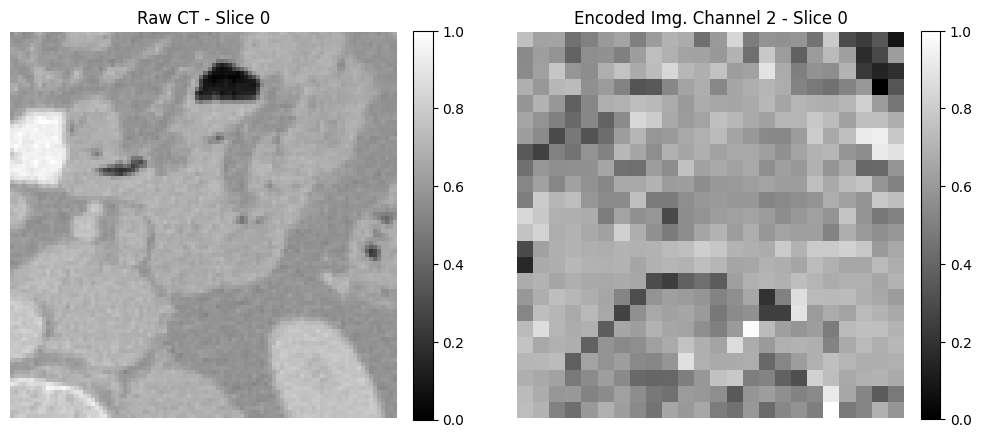

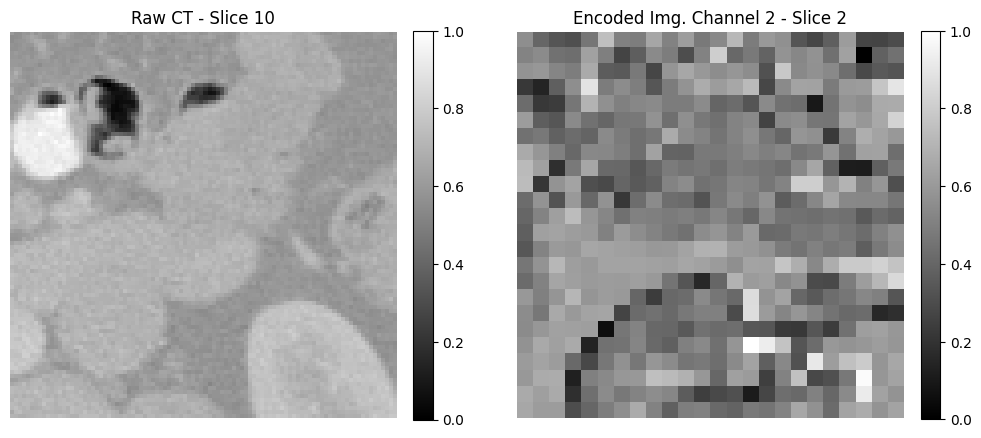

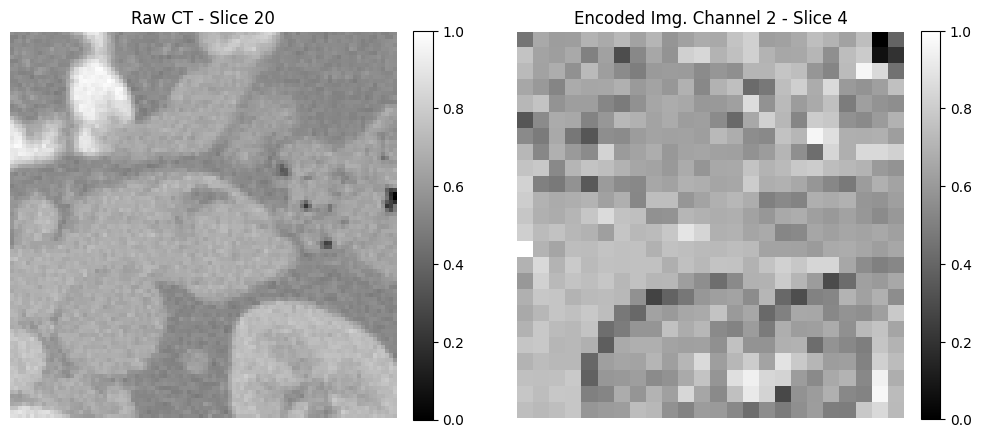

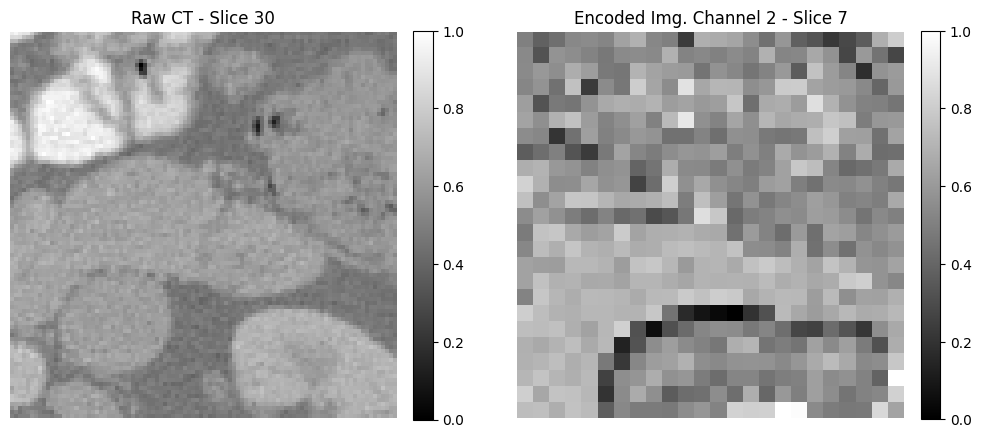

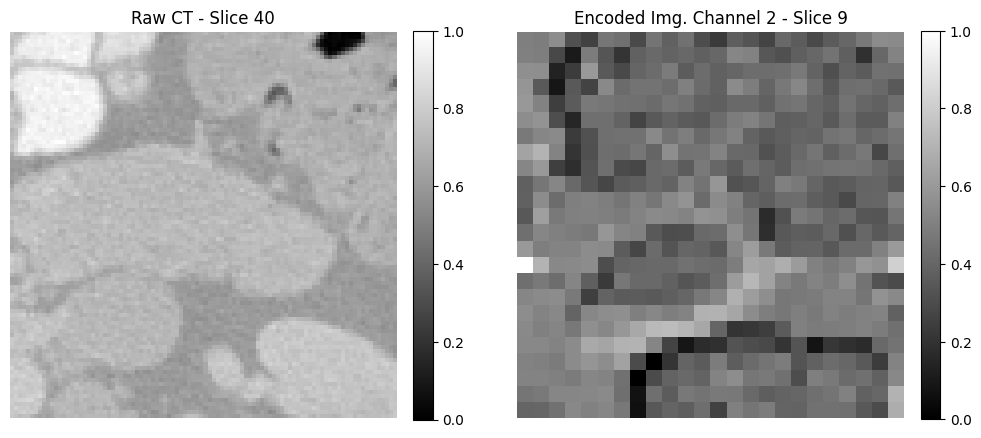

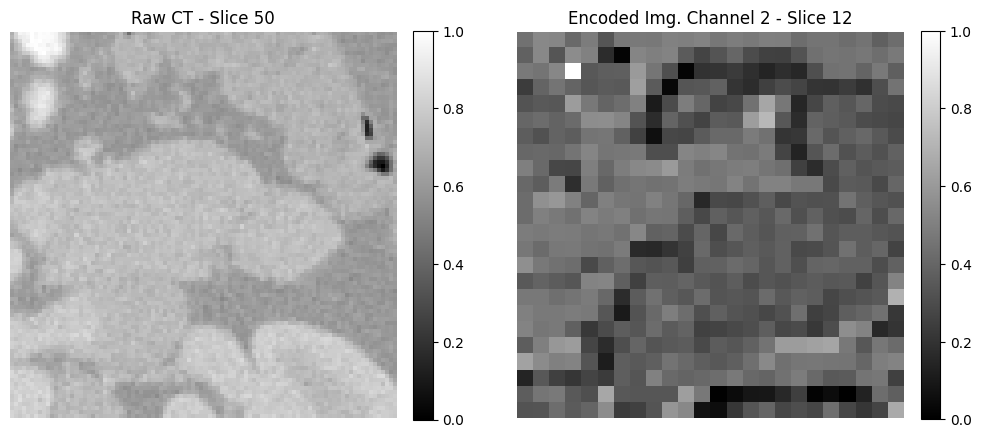

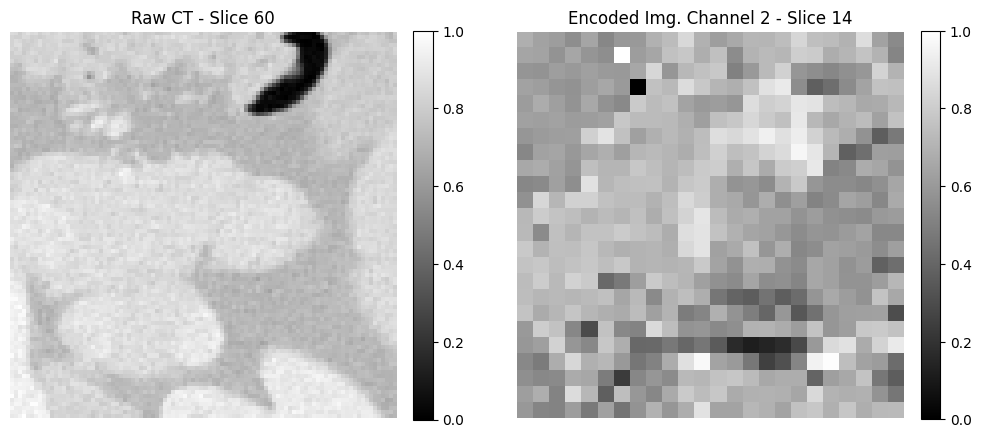

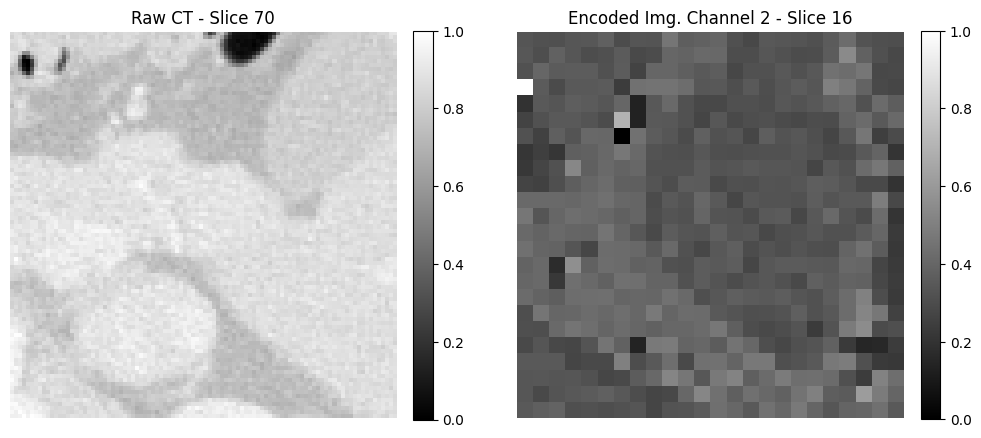

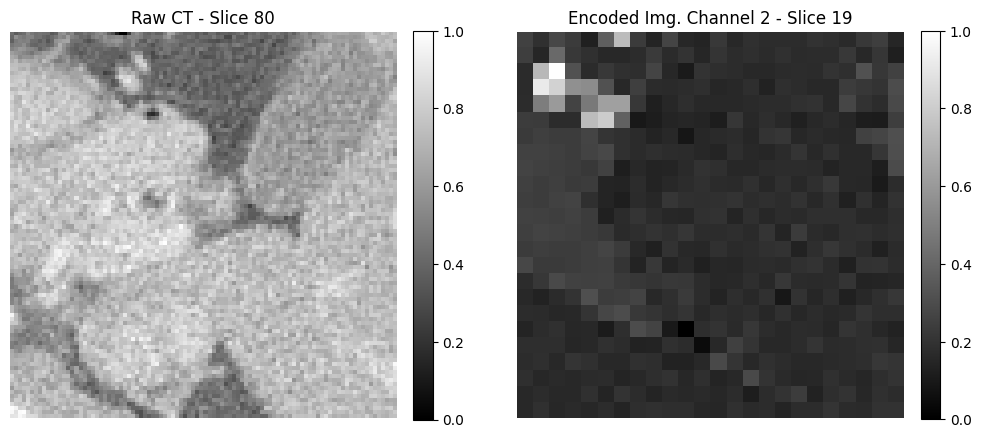

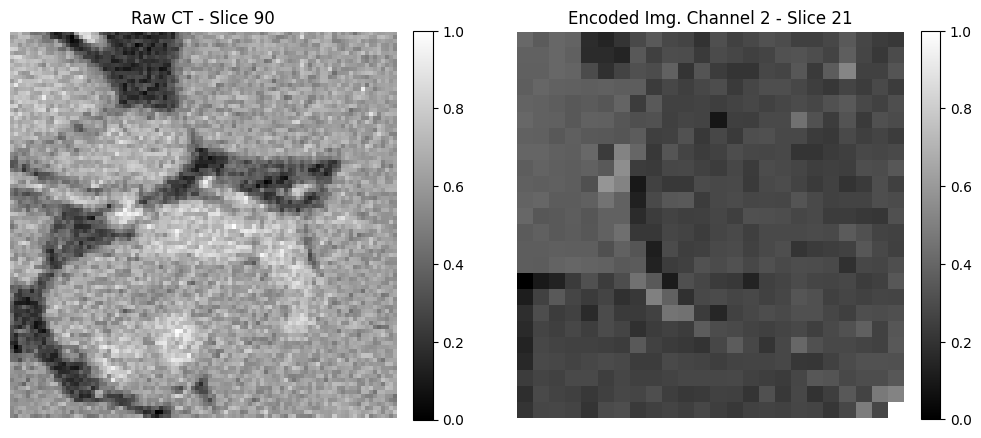

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Loop for side-by-side plotting
for i in range(10):  # Both loops generate 10 plots
    slice_idx_1 = i * 10  # From the first loop (0-96, step 10)
    slice_idx_2 = i * 2.4  # From the second loop (0-24), scaling to match the count

    # Create a figure with 2 subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Rotate and normalize the first image
    img_1 = all_sampled_cubes[0, 0, :, :, int(slice_idx_1)].cpu().numpy()
    img_1_normalized = (img_1 - img_1.min()) / (img_1.max() - img_1.min())  # Normalization to [0, 1]
    rotated_img_1 = np.rot90(img_1_normalized)
    ax[0].imshow(rotated_img_1, cmap="gray")
    ax[0].set_title(f"Raw CT - Slice {int(slice_idx_1)}")
    ax[0].axis('off')  # Remove axis for cleaner visualization

    # Rotate and normalize the second image
    channel_idx = 2
    img_2 = enc_img[channel_idx, :, :, int(slice_idx_2)].cpu().numpy()
    img_2_normalized = (img_2 - img_2.min()) / (img_2.max() - img_2.min())  # Normalization to [0, 1]
    rotated_img_2 = np.rot90(img_2_normalized)
    ax[1].imshow(rotated_img_2, cmap="gray")
    ax[1].set_title(f"Encoded Img. Channel {channel_idx} - Slice {int(slice_idx_2)}")
    ax[1].axis('off')  # Remove axis for cleaner visualization

    # Add colorbars to each subplot
    fig.colorbar(ax[0].images[0], ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(ax[1].images[0], ax=ax[1], fraction=0.046, pad=0.04)

    # Display the figure
    plt.show()

In [25]:
list(enc_healthy_cubes.values())[0][0].shape

torch.Size([1, 8, 24, 24, 24])

<Figure size 640x480 with 0 Axes>

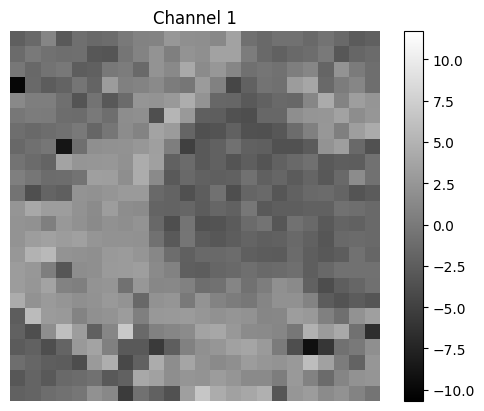

<Figure size 640x480 with 0 Axes>

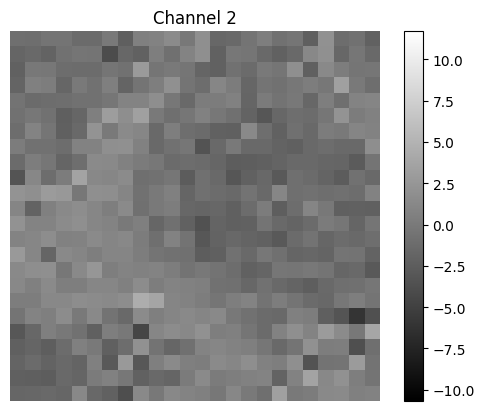

<Figure size 640x480 with 0 Axes>

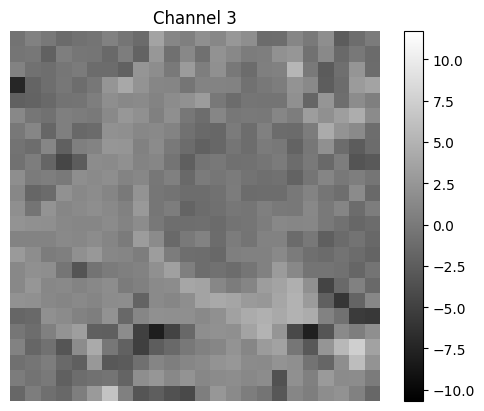

<Figure size 640x480 with 0 Axes>

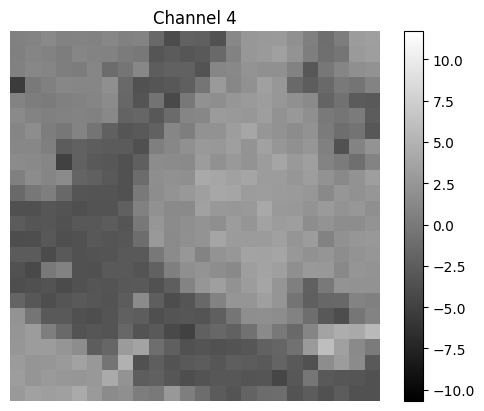

<Figure size 640x480 with 0 Axes>

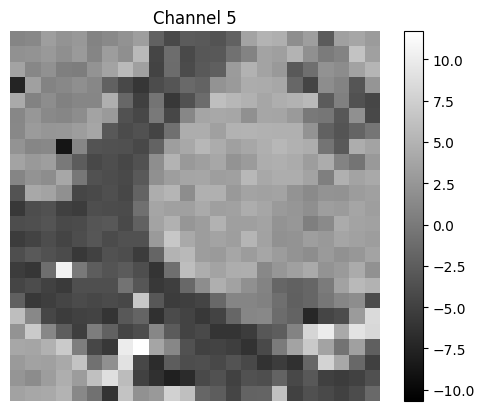

<Figure size 640x480 with 0 Axes>

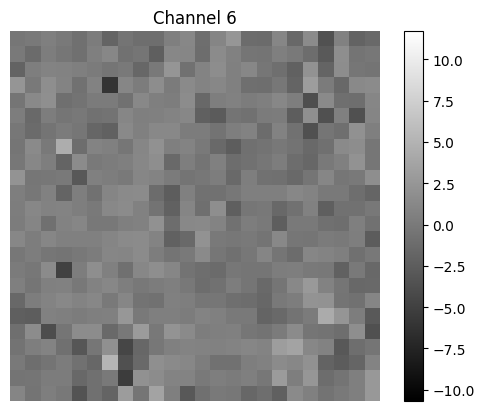

<Figure size 640x480 with 0 Axes>

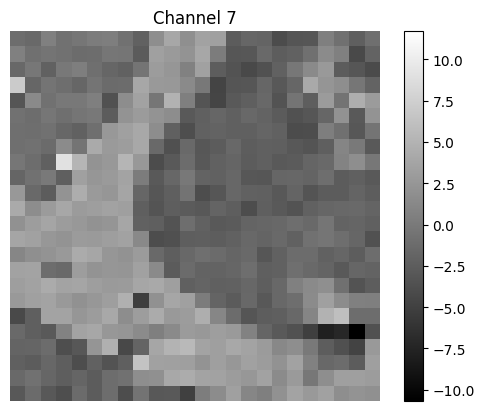

<Figure size 640x480 with 0 Axes>

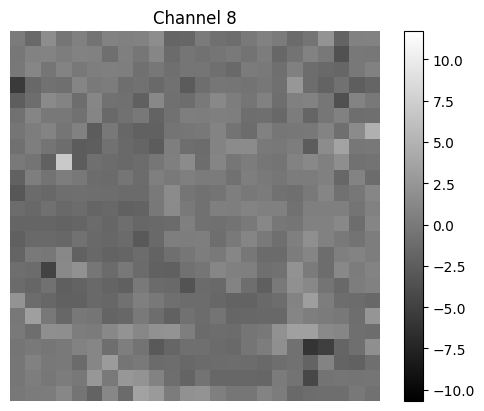

In [27]:
from matplotlib import pyplot as plt
import numpy as np

slice_idx = 15#60 // 4

vmin = enc_img[:, :, :, slice_idx].min().item()
vmax = enc_img[:, :, :, slice_idx].max().item()

for channel in range(enc_img.shape[0]):
    plt.figure()
    fig, ax = plt.subplots()

    # Rotate the image 90 degrees counterclockwise
    rotated_img = np.rot90(enc_img[channel, :, :, slice_idx].cpu().numpy())

    plt.imshow(rotated_img, vmin=vmin, vmax=vmax, cmap="gray")
    plt.title(f"Channel {channel+1}")

    plt.colorbar()
    
    plt.axis('off')  # Remove axis for cleaner visualization
    
    
    plt.show()

<font color="Purple">

#### GAN Hates -1000 Padded images, why?

</font>

gives checkerboard output